In [2]:
a=[1,2,3,4,5,6,7,8,9]
b=[9,8,7,6,5,4,3,2,1]
c=[5,5,5,5,5,5,5,5,5]
import numpy
d=numpy.vstack((a,b,c))
print(a)
print(b)
print(c)
print(d)
numpy.savetxt('Test_Text_File.txt',d)
e=numpy.loadtxt('Test_Text_File.txt')
print(e)
a=e[0,:]
b=e[1,:]
c=e[2,:]
print(a)
print(b)
print(c)
DataArray=numpy.loadtxt('Ophiuchus_DR_2_Data.txt')
StarRA=DataArray[0,:]
StarRAError=DataArray[1,:]
StarDec=DataArray[2,:]
StarDecError=DataArray[3,:]
StarParallax=DataArray[4,:]
StarParallaxError=DataArray[5,:]
ParallaxCount=len(StarParallax)
TotalStarNumber=336739
ParallaxPercentage=(ParallaxCount/TotalStarNumber)*100
print('The number of stars in this data set which have parallaxes provided is:',ParallaxCount,'(%g percent)'%(ParallaxPercentage))
StarParallaxArcsec=(1/1000)*StarParallax
StarDistance=1/StarParallaxArcsec
print('Done')

[1, 2, 3, 4, 5, 6, 7, 8, 9]
[9, 8, 7, 6, 5, 4, 3, 2, 1]
[5, 5, 5, 5, 5, 5, 5, 5, 5]
[[1 2 3 4 5 6 7 8 9]
 [9 8 7 6 5 4 3 2 1]
 [5 5 5 5 5 5 5 5 5]]
[[1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [9. 8. 7. 6. 5. 4. 3. 2. 1.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5.]]
[1. 2. 3. 4. 5. 6. 7. 8. 9.]
[9. 8. 7. 6. 5. 4. 3. 2. 1.]
[5. 5. 5. 5. 5. 5. 5. 5. 5.]
The number of stars in this data set which have parallaxes provided is: 249711 (74.1557 percent)
Done


In [3]:
from astropy.table import Table
import matplotlib.pyplot as plt
import math
import numpy
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
import warnings
import time
import sklearn
from sklearn.neighbors import NearestNeighbors
import scipy
from scipy  import spatial
from numpy import loadtxt
import sys
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import pandas
import csv
#Imports possibly useful Python software to use
plt.clf()
plt.cla()
plt.close()
#Clears figure and erases it so that figures can be made later
warnings.filterwarnings('ignore')
#Ignores Python warnings so that they don't show up

In [13]:
def PixelSetup(StarRA,StarDec,N):
    #Does math to shift and normalize arrays and makes pixels
    #Parameter StarRA is array of the star right ascensions
    #Parameter StarDec is array of the star declinations
    #Parameter N is the number of pixels desired on each side
    RAStDev=numpy.std(StarRA)
    DecStDev=numpy.std(StarDec)
    #Computes standard deviations of each array
    RAAverage=numpy.average(StarRA)
    DecAverage=numpy.average(StarDec)
    #Computes averages of each array
    RA=StarRA-RAAverage
    RA=RA/RAStDev
    Dec=StarDec-DecAverage
    Dec=Dec/DecStDev
    #Shifts and normalizes the RA and Dec so they are easy to work with
    RAPixels=numpy.linspace(RAMin,RAMax,N)
    DecPixels=numpy.linspace(DecMin,DecMax,N)
    #Creates linearly spaced pixel arrays for next step
    RAPixels=RAPixels-RAAverage
    RAPixels=RAPixels/RAStDev
    DecPixels=DecPixels-DecAverage
    DecPixels=DecPixels/DecStDev
    #Shifts and normalizes pixels to match format
    Pixels2D=numpy.zeros([N,N])
    #Makes two-dimensional pixels array for next steps
    RAPixels=numpy.asarray(RAPixels)
    DecPixels=numpy.asarray(DecPixels)
    return (RAStDev,DecStDev,RAAverage,DecAverage,RA,Dec,RAPixels,DecPixels,Pixels2D)
def NearestNeighbor3D(k,DistanceMin,DistanceMax,RA,Dec,Distance):
    #Finds the kth nearest neighbor distances and indices in three dimensions using cKDTree algorithm
    #Parameter k is kth nearest neighbor desired
    #Parameter DistanceMin is the minimum distance of the range
    #Parameter DistanceMax is the maximum distance of the range
    #Parameter RA is the shifted and normalized star RA array
    #Parameter Dec is the shifted and normalized star declination array
    #Parameter Distance is the shifted and normalized star distance array
    tic=time.time()
    #Gets starting time
    DistancePixels=numpy.linspace(DistanceMin,DistanceMax,N)
    DistancePixels=DistancePixels-DistanceAverage
    DistancePixels=DistancePixels/DistanceStDev
    DistancePixels=numpy.asarray(DistancePixels)
    #Produces distance pixel array
    Pixels=numpy.zeros([N,N,N])
    StarArray=numpy.vstack((RA,Dec,Distance))
    StarArray=numpy.transpose(StarArray)
    #Prepares star location three dimensional array
    NumberOfPoints=N*N*N
    PixelArray=numpy.zeros((NumberOfPoints,3))
    i=0
    for RA in RAPixels:
        for Dec in DecPixels:
            for Distance in DistancePixels:
                PixelArray[i,0]=RA
                PixelArray[i,1]=Dec
                PixelArray[i,2]=Distance
                i+=1
    #Prepares pixel grid three dimensional array
    tree=spatial.cKDTree(StarArray)
    #Sets up the cKDTree structure to query through
    NumberOfNeighbors=k
    #Redefines the number of neighbors as k for function usage
    Distances3D,Indices3D=tree.query(PixelArray,k=[NumberOfNeighbors])
    #Uses cKDTree algorithm to get kth nearest neighbor distances and indices
    print('Done')
    toc=time.time()
    #Gets final time
    ElapsedTime=toc-tic
    ElapsedTimeMinutes=ElapsedTime/60
    print('Elapsed Time:',ElapsedTime,'seconds')
    print('Elapsed Time:',ElapsedTimeMinutes,'minutes')
    #Shows how long the function took to run
    return (DistancePixels,StarArray,NumberOfPoints,Distances3D,Indices3D);
def DistanceMap3D(Distances3D):
    #Creates the three-dimensional kth nearest neighbor distance arrays needed and plots in 3D the distance map
    #Also creates three-dimensional plot of star locations for comparison and combines these plots
    #Parameter Distances3D is the sequence of three-dimensional kth nearest neighbor distances
    tic=time.time()
    #Gets starting time
    fig=plt.figure()
    ax=plt.axes(projection='3d')
    #Sets up a new figure and establishes the settings as three-dimensional
    x=numpy.linspace(RAMin,RAMax,N)
    y=numpy.linspace(DecMin,DecMax,N)
    z=numpy.linspace(DistanceMin,DistanceMax,N)
    #Making fresh array of linearly spaced points for each axis
    PlotPixelArray=numpy.zeros((NumberOfPoints,3))
    #Creates list with 3 columns to be used for plotting later
    i=0
    for RA in x:
        for Dec in y:
            for Distance in z:
                PlotPixelArray[i,0]=RA
                PlotPixelArray[i,1]=Dec
                PlotPixelArray[i,2]=Distance
                i+=1
    X=PlotPixelArray[:,0]
    Y=PlotPixelArray[:,1]
    Z=PlotPixelArray[:,2]
    #Uses a loop to cycle through all grid points and makes X, Y, and Z vectors to plot
    Pixels=numpy.zeros([N,N,N])
    #Makes 3D grid array of zeros
    for RA in range(0,N):
        for Dec in range(0,N):
            for Distance in range(0,N):
                Pixels[RA,Dec,Distance]=Distances3D[RA+Dec+Distance]
    #Sets as each element in the 3D grid array the kth nearest neighbor distance
    plt.rcParams['figure.figsize']=12,12
    plt.rcParams['axes.facecolor']='white'
    #Sets the figure size and background color
    Distances3D=numpy.ndarray.flatten(Distances3D)
    #Flattens the distances array into a one-dimensional vector for use as a color mapping
    Map3D=ax.scatter3D(X,Y,Z,c=Distances3D,cmap='viridis',marker='o',s=0.5,depthshade=True,alpha=0.2)
    #Plots in 3D translucent vectors with the color map as the kth nearest neighor distance with opacity varying to show depth
    plt.title('3D Distance Map for Nearest Neighbor %g'%(k))
    ax.set_xlabel('Right Ascension (degrees)')
    ax.set_xlim([RAMin,RAMax])
    ax.set_ylabel('Declination (degrees)')
    ax.set_ylim([DecMin,DecMax])
    ax.set_zlabel('Distance (pc)')
    ax.set_zlim([DistanceMin,DistanceMax])
    #Makes appropriate title, axis labels, and limits for variables
    cbar=fig.colorbar(Map3D,shrink=0.75)
    cbar.set_label('3D (RA/Declination/Distance) Distance',rotation='90')
    #Adds a color bar for the 3D distance, labels it, and rotates the label
    plt.show()
    fig=plt.figure()
    ax=plt.axes(projection='3d')
    #Creates another new figure and reestablishes 3D axis settings
    plt.rcParams['figure.figsize']=12,12
    plt.rcParams['axes.facecolor']='white'
    ax.scatter3D(X,Y,Z,c=Distances3D,cmap='viridis',marker='o',s=0.5,depthshade=True,alpha=0.2)
    #Plots in 3D translucent vectors with the color map as the kth nearest neighor distance with opacity varying to show depth
    cbar=fig.colorbar(Map3D,shrink=0.75)
    cbar.set_label('3D (RA/Declination/Distance) Distance',rotation='90')
    #Adds a color bar for the 3D distance, labels it, and rotates the label
    ax.scatter3D(StarRA,StarDec,StarDistance,c='xkcd:white',marker='*',s=20,depthshade=True)
    #Plots the three-dimensional position of all stars as white stars with opacity varying to show depth
    plt.title('3D Distance Map with Star Locations for Nearest Neighbor %g'%(k))
    ax.set_xlabel('Right Ascension (degrees)')
    ax.set_xlim([RAMin,RAMax])
    ax.set_ylabel('Declination (degrees)')
    ax.set_ylim([DecMin,DecMax])
    ax.set_zlabel('Distance (pc)')
    ax.set_zlim([DistanceMin,DistanceMax])
    #Makes appropriate title, axis labels, and limits for variables
    plt.show()
    toc=time.time()
    #Gets final time
    ElapsedTime=toc-tic
    ElapsedTimeMinutes=ElapsedTime/60
    print('Elapsed Time:',ElapsedTime,'seconds')
    print('Elapsed Time:',ElapsedTimeMinutes,'minutes')
    #Shows how long the function took to run
    return (PlotPixelArray,X,Y,Z,Pixels)

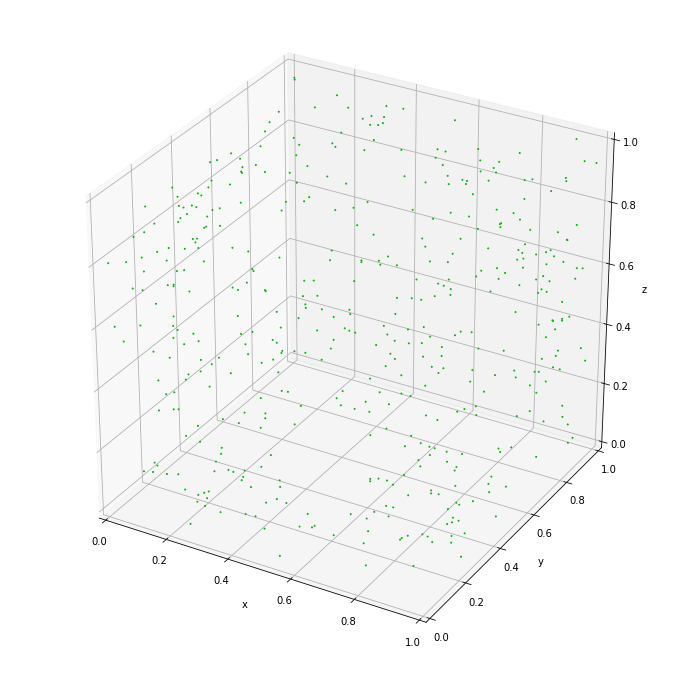

In [5]:
testx=numpy.random.random_sample((1000,))
testy=numpy.random.random_sample((1000,))
testz=numpy.random.random_sample((1000,))
testx=numpy.asarray(testx)
testy=numpy.asarray(testy)
testz=numpy.asarray(testz)
for i in range(0,len(testx)):
    dist=numpy.sqrt((testx[i]-0.5)**2+(testy[i]-0.5)**2+(testz[i]-0.5)**2)
    if dist<=0.5:
        testz[i]=15
pixelx=numpy.linspace(0,1,100)
pixely=numpy.linspace(0,1,100)
pixelz=numpy.linspace(0,1,100)
NumberOfPoints=100**3
pixelarray=numpy.zeros((NumberOfPoints,3))
i=0
for x in pixelx:
    for y in pixely:
        for z in pixelz:
            pixelarray[i,0]=x
            pixelarray[i,1]=y
            pixelarray[i,2]=z
            i+=1
pixelx=pixelarray[:,0]
pixely=pixelarray[:,1]
pixelz=pixelarray[:,2]
fig=plt.figure()
ax=plt.axes(projection='3d')
plt.rcParams['figure.figsize']=12,12
plt.rcParams['axes.facecolor']='white'
ax.scatter3D(testx,testy,testz,marker='o',c='xkcd:green',s=1,alpha=1,depthshade=True)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_zlim([0,1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.rcParams['figure.figsize']=12,12
plt.show()

Done
Elapsed Time: 6.244305610656738 seconds
Elapsed Time: 0.1040717601776123 minutes


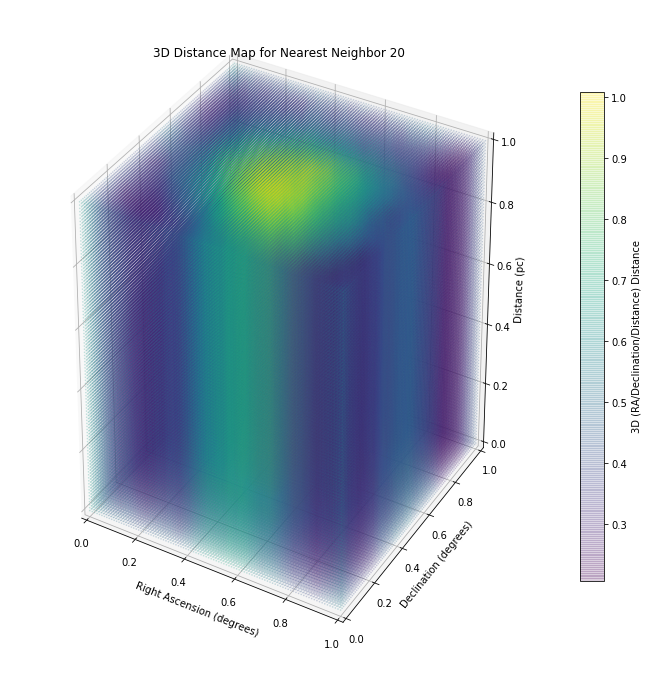

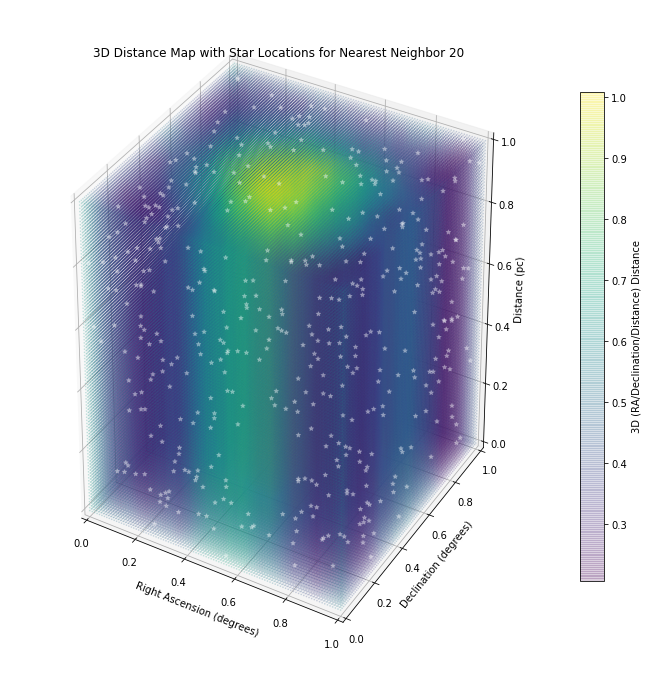

Elapsed Time: 272.72225761413574 seconds
Elapsed Time: 4.545370960235596 minutes


In [14]:
DistanceMin=0
DistanceMax=1
RAMin=0
RAMax=1
DecMin=0
DecMax=1
k=20
n=25
StarRA=testx
StarDec=testy
StarDistance=testz
RAAverage=numpy.average(StarRA)
RAStDev=numpy.std(StarRA)
DecAverage=numpy.average(StarDec)
DecStDev=numpy.std(StarDec)
DistanceAverage=numpy.average(StarDistance)
DistanceStDev=numpy.std(StarDistance)
RA=StarRA-RAAverage
RA=RA/RAStDev
Dec=StarDec-DecAverage
Dec=Dec/DecStDev
Distance=StarDistance-DistanceAverage
Distance=Distance/DistanceStDev
N=100
RAStDev,DecStDev,RAAverage,DecAverage,RA,Dec,RAPixels,DecPixels,Pixels2D=PixelSetup(StarRA,StarDec,N)
DistancePixels,StarArray,NumberOfPoints,Distances3D,Indices3D=NearestNeighbor3D(k,DistanceMin,DistanceMax,RA,Dec,Distance)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['figure.figsize']=12,12
PlotPixelArray,X,Y,Z,Pixels=DistanceMap3D(Distances3D)